This script demonstrates how to run the simulation with 3D illumination, I(x,y,lambda), i.e., the illumination is wavelength-dependent.

In [2]:
import os
import unittest
import timeit
import os
import numpy as np
import matplotlib.pyplot as plt
import typing
from skimage.io import imread, imsave

from pypvcell.solarcell import SQCell, MJCell
from pypvcell.illumination import load_astm
from pypvcell.fom import isc, ff

from tests.helper import draw_contact_and_voltage_map, draw_merged_contact_images, \
    get_quater_image, contact_ratio, draw_illumination_3d

from pypvcircuit.parse_spice_input import NodeReducer
from pypvcircuit.spice_solver import SPICESolver, SPICESolver3D
from pypvcircuit.util import make_3d_illumination, gen_profile, HighResGrid, MetalGrid
from pypvcircuit.import_tool import RayData

import yaml

## Load the mask

In [9]:
mask_file="tests/masks_sq_no_shades.png"

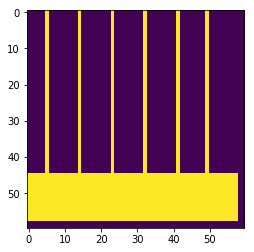

In [8]:
default_contactsMask = imread(mask_file)
# Load metal mask
metal_mask = get_quater_image(default_contactsMask)
plt.figure()

plt.imshow(metal_mask)
plt.show()

## Load the illumination from ray data exported by LightTools

In [10]:
# Load the illumination from ray data
# TODO the file path is temporary
file = "private_data/export_rays_binary_1mm.1.ray"
if not os.path.exists(file):
    raise FileNotFoundError("No ray data found in private_data folder")

rd = RayData(file)
illumination_mask_3d, wl = rd.get_ill_mtx(r_pixel=metal_mask.shape[0],
                                          c_pixel=metal_mask.shape[1], r_max=0.5, r_min=-0.5,
                                          c_max=6.5, c_min=5.5)

### Show the profile

/Users/kanhua/miniconda3/envs/solcore5/lib/python3.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


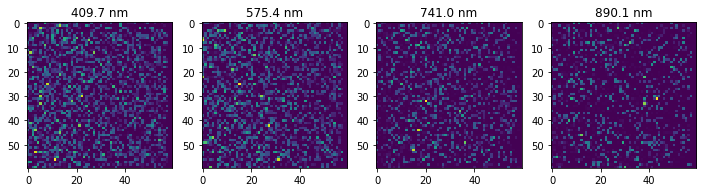

In [11]:
wllen = wl.size

fig, ax = draw_illumination_3d(illumination_mask_3d, wl, [0, int(wllen / 3), int(wllen / 3 * 2), -1])

fig.show()

In [14]:
gaas_1j = SQCell(1.42, 300, 1)
ingap_1j = SQCell(1.87, 300, 1)
ge_1j = SQCell(0.7, 300, 1)
mj_cell = MJCell([ingap_1j, gaas_1j, ge_1j])

In [17]:
l_r=1e-6 #pixel height
l_c=1e-6 #pixel width
h=2.2e-6

In [20]:
pw = 5

vini=0
vfin = 3.0
step = 0.02


nd = NodeReducer()

input_spectrum = load_astm("AM1.5g")

wavelength_data, _ = input_spectrum.get_spectrum(to_x_unit='nm')

mj_cell.set_input_spectrum(input_spectrum)

sps = SPICESolver3D(solarcell=mj_cell, illumination=illumination_mask_3d,
                    metal_contact=metal_mask, rw=pw, cw=pw, v_start=vini, v_end=vfin,
                    v_steps=step,
                    l_r=l_r, l_c=l_c, h=h, spice_preprocessor=nd,
                    illumination_wavelength=wl, illumination_unit='W')

number of data:151


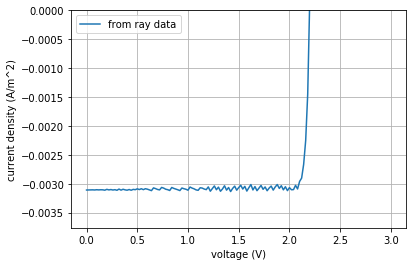

3D illumination solver isc:-1.1194089000520994e-11


In [25]:
device_area = (metal_mask.size * l_c * l_r)

plt.figure()
plt.plot(sps.V, sps.I / device_area, label="from ray data")

plt.xlabel("voltage (V)")
plt.ylabel("current density (A/m^2)")
plt.grid()
plt.legend()

plt.ylim(ymax=0, ymin=np.min(sps.I / device_area) * 1.2)

plt.savefig(os.path.join("tmp_out", "raydata_iv.png"), dpi=300)

plt.show()

mj_cell.set_input_spectrum(load_astm("AM1.5g"))
# estimated_isc = self.gaas_1j.jsc * self.lc * self.lr * np.sum(illumination_mask_2d * not_metal)
# device_photo_active_area=self.lc*self.lr*np.sum()
# print(estimated_isc)
print("3D illumination solver isc:{}".format(sps.I[0]))
# print(self.gaas_1j.jsc)